✅ Dataset shape after cleaning: (406829, 11)
✅ Total Cancellations: 8905
✅ Cancellation metrics calculated.


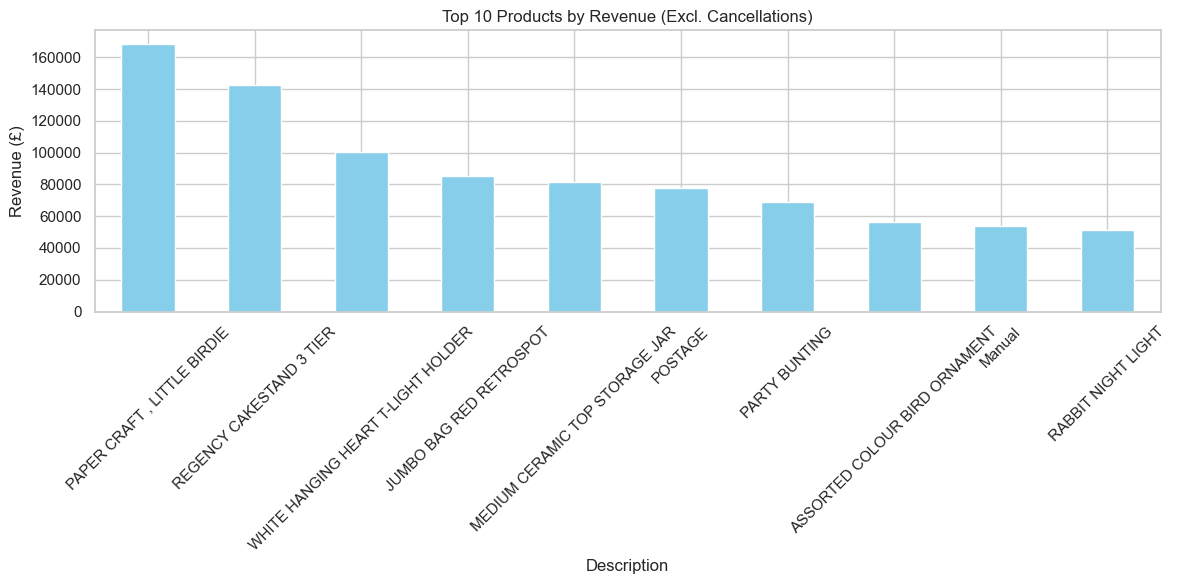

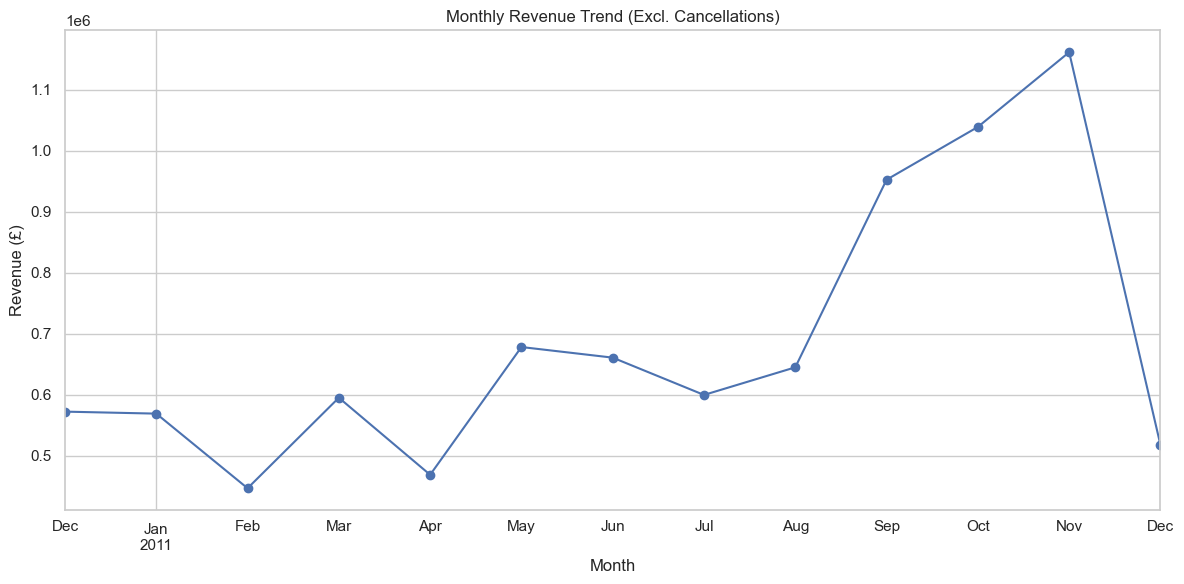

/var/folders/27/df1qvxrx6759j93c0m03nlcm0000gn/T/ipykernel_42563/4123440551.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue.head(10).index, y=country_revenue.head(10).values, palette="viridis")


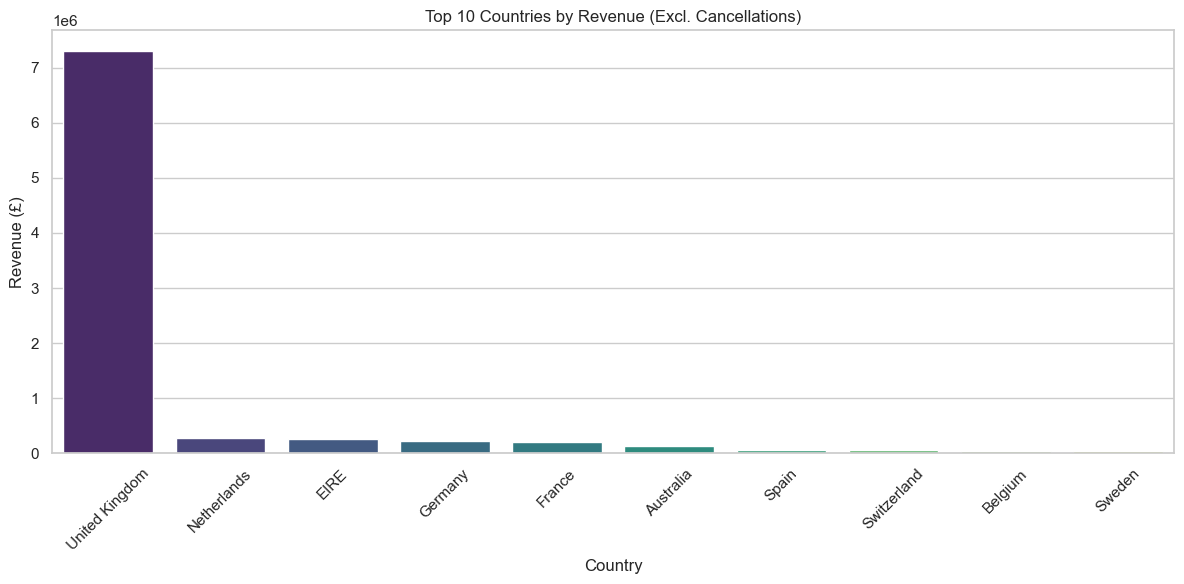

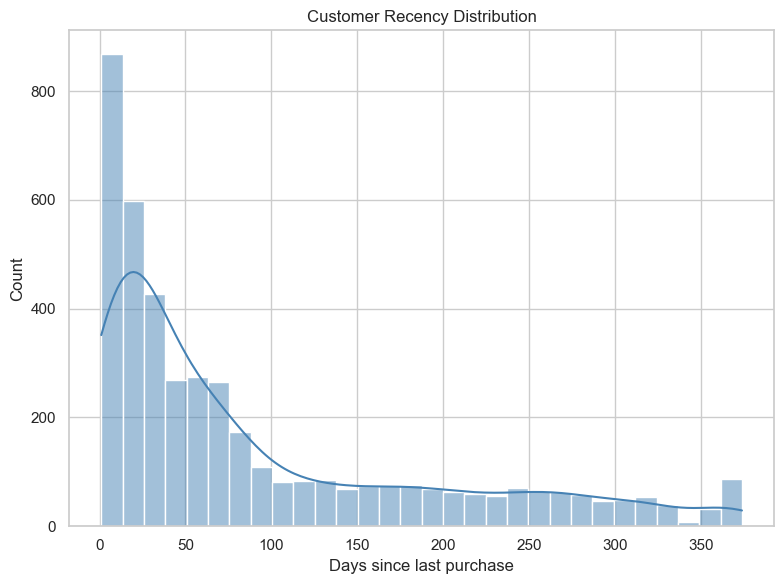

📊 Key Business Metrics (Excl. Cancellations)
- Average Order Value (AOV): £480.76
- Customer Lifetime Value (avg CLV): £2053.79
- Repeat Purchase Rate: 65.57%
- % Revenue from Top 20% Customers: 74.59%
- Churn Rate (90 days inactive): 33.60%

📊 Cancellation Metrics
- Total_Cancellations: 3654
- Total_Cancelled_Items: -274808
- Total_Cancelled_Value: -611342.0900000001
- Cancellation_Rate_Invoices: 16.47%
- Cancellation_Rate_Revenue: 7.37%


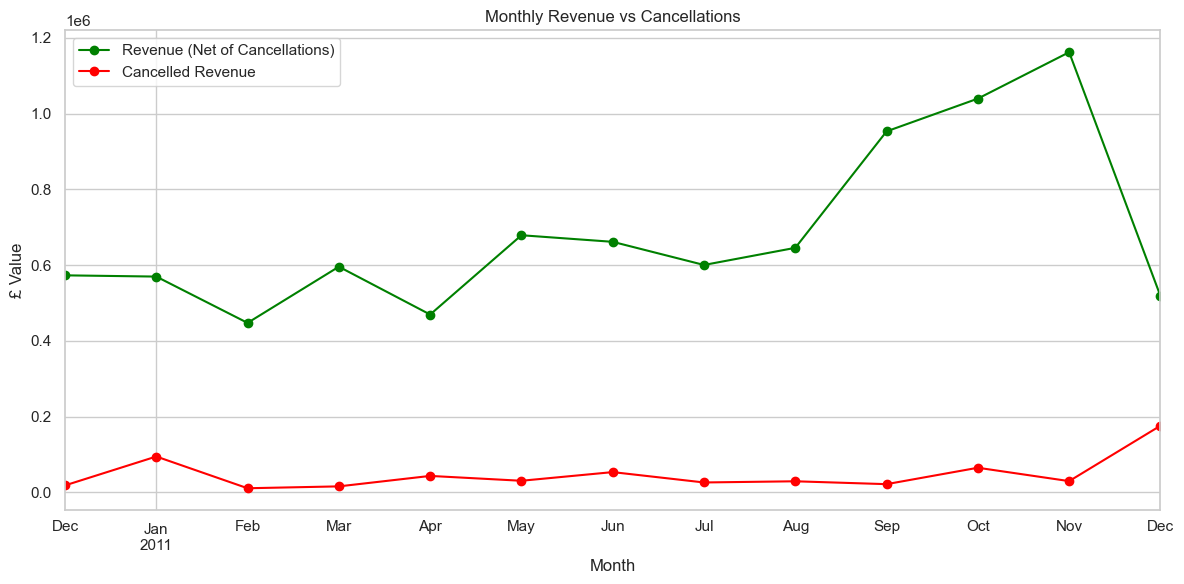

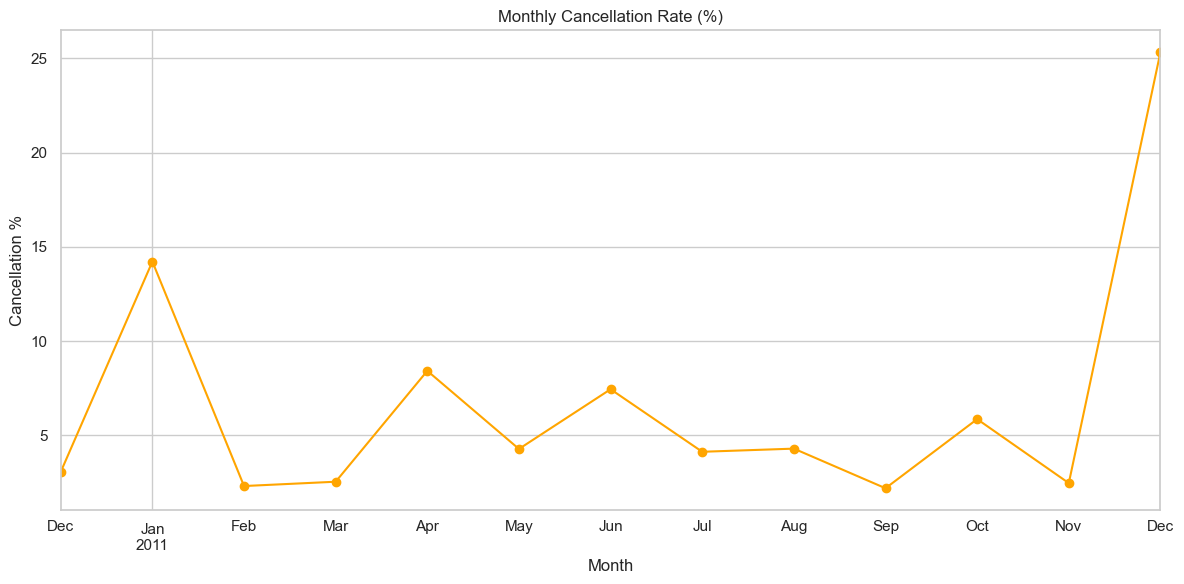

📊 KPI Dashboard Summary


,Metric,Value
0,Average Order Value (AOV),£480.76
1,"Customer Lifetime Value (CLV, avg)",£2053.79
2,Repeat Purchase Rate,65.57%
3,Pareto Share (Top 20% Customers Revenue Share),74.59%
4,Churn Rate (90 days inactive),33.60%
5,Total Cancellations,3654
6,Cancelled Items,-274808
7,Cancelled Value (£),£-611342.09
8,Cancellation Rate (Invoices),16.47%
9,Cancellation Rate (Revenue),7.37%


In [5]:
# ==============================
# 📦 Online Retail Analysis (with Cancellations)
# ==============================

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Display settings
pd.set_option("display.float_format", lambda x: "%.2f" % x)
sns.set(style="whitegrid")

# === 2. Load Data ===

try:
    df = pd.read_csv("/Users/micic/Downloads/data.csv", encoding='utf-8')
except UnicodeDecodeError:
    # Fallback to ISO-8859-1
    df = pd.read_csv("/Users/micic/Downloads/data.csv", encoding='ISO-8859-1')


# === 3. Data Cleaning ===
df.dropna(subset=["CustomerID"], inplace=True)
df = df[df["Quantity"] != 0]   # keep cancellations but remove zero-quantity rows

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Month"] = df["InvoiceDate"].dt.to_period("M")

# Flag cancellations
df["IsCancellation"] = df["InvoiceNo"].astype(str).str.startswith("C")

print(f"✅ Dataset shape after cleaning: {df.shape}")
print(f"✅ Total Cancellations: {df['IsCancellation'].sum()}")

# === 4. Sales & Revenue Metrics ===
# Top 10 Products by Revenue (exclude cancellations)
top_products = df[~df["IsCancellation"]].groupby("Description")["TotalPrice"].sum().nlargest(10)

# Revenue by Country (net of cancellations)
country_revenue = df[~df["IsCancellation"]].groupby("Country")["TotalPrice"].sum().sort_values(ascending=False)

# Monthly Revenue (net of cancellations)
monthly_revenue = df[~df["IsCancellation"]].groupby("Month")["TotalPrice"].sum()

# KPIs (exclude cancellations for revenue-related metrics)
aov = df[~df["IsCancellation"]].groupby("InvoiceNo")["TotalPrice"].sum().mean()
clv = df[~df["IsCancellation"]].groupby("CustomerID")["TotalPrice"].sum().mean()
purchase_freq = df[~df["IsCancellation"]].groupby("CustomerID")["InvoiceNo"].nunique()
repeat_purchase_rate = (purchase_freq > 1).mean()

customer_revenue = df[~df["IsCancellation"]].groupby("CustomerID")["TotalPrice"].sum().sort_values(ascending=False)
top_20_percent_cutoff = int(len(customer_revenue) * 0.2)
pareto_share = customer_revenue.iloc[:top_20_percent_cutoff].sum() / customer_revenue.sum()

# Churn (customers inactive in last 90 days)
analysis_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
recent_purchase = df[~df["IsCancellation"]].groupby("CustomerID")["InvoiceDate"].max()
churn_rate = (recent_purchase < (analysis_date - pd.Timedelta(days=90))).mean()

# === 5. Cancellation Metrics ===
cancellations = df[df["IsCancellation"]]

cancellation_summary = {
    "Total_Cancellations": cancellations["InvoiceNo"].nunique(),
    "Total_Cancelled_Items": cancellations["Quantity"].sum(),
    "Total_Cancelled_Value": cancellations["TotalPrice"].sum(),
    "Cancellation_Rate_Invoices": cancellations["InvoiceNo"].nunique() / df["InvoiceNo"].nunique(),
    "Cancellation_Rate_Revenue": abs(cancellations["TotalPrice"].sum()) / df["TotalPrice"].sum()
}

print("✅ Cancellation metrics calculated.")

# === 6. Customer Segmentation (RFM, exclude cancellations) ===
rfm = df[~df["IsCancellation"]].groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (analysis_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})
rfm.columns = ["Recency", "Frequency", "Monetary"]

# Score RFM
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)

# === 7. Visualizations ===
os.makedirs("plots", exist_ok=True)

# === 7. Visualizations ===
plt.figure(figsize=(12,6))
top_products.plot(kind="bar", color="skyblue")
plt.title("Top 10 Products by Revenue (Excl. Cancellations)")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/top_products.png")
plt.show()

plt.figure(figsize=(12,6))
monthly_revenue.plot(marker="o")
plt.title("Monthly Revenue Trend (Excl. Cancellations)")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.savefig("plots/monthly_revenue.png")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=country_revenue.head(10).index, y=country_revenue.head(10).values, palette="viridis")
plt.title("Top 10 Countries by Revenue (Excl. Cancellations)")
plt.xticks(rotation=45)
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.savefig("plots/top_countries.png")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(rfm["Recency"], bins=30, kde=True, color="steelblue")
plt.title("Customer Recency Distribution")
plt.xlabel("Days since last purchase")
plt.tight_layout()
plt.savefig("plots/recency_distribution.png")
plt.show()

# === 8. KPI Summary ===
print("📊 Key Business Metrics (Excl. Cancellations)")
print(f"- Average Order Value (AOV): £{aov:.2f}")
print(f"- Customer Lifetime Value (avg CLV): £{clv:.2f}")
print(f"- Repeat Purchase Rate: {repeat_purchase_rate:.2%}")
print(f"- % Revenue from Top 20% Customers: {pareto_share:.2%}")
print(f"- Churn Rate (90 days inactive): {churn_rate:.2%}")

print("\n📊 Cancellation Metrics")
for k,v in cancellation_summary.items():
    if "Rate" in k:
        print(f"- {k}: {v:.2%}")
    else:
        print(f"- {k}: {v}")

# === 9. Cancellation Visualizations ===

# Monthly cancellations (absolute value of cancelled revenue)
monthly_cancellations = cancellations.groupby("Month")["TotalPrice"].sum()

plt.figure(figsize=(12,6))
monthly_revenue.plot(marker="o", label="Revenue (Net of Cancellations)", color="green")
monthly_cancellations.abs().plot(marker="o", label="Cancelled Revenue", color="red")
plt.title("Monthly Revenue vs Cancellations")
plt.ylabel("£ Value")
plt.legend()
plt.tight_layout()
plt.savefig("plots/cancellations_vs_revenue.png")
plt.show()

# Cancellation rate per month (% of revenue cancelled)
monthly_cancellation_rate = (monthly_cancellations.abs() / (monthly_revenue + monthly_cancellations.abs())) * 100

plt.figure(figsize=(12,6))
monthly_cancellation_rate.plot(marker="o", color="orange")
plt.title("Monthly Cancellation Rate (%)")
plt.ylabel("Cancellation %")
plt.tight_layout()
plt.savefig("plots/cancellation_rate.png")
plt.show()

# === 10. KPI Dashboard ===

kpi_dashboard = pd.DataFrame({
    "Metric": [
        "Average Order Value (AOV)",
        "Customer Lifetime Value (CLV, avg)",
        "Repeat Purchase Rate",
        "Pareto Share (Top 20% Customers Revenue Share)",
        "Churn Rate (90 days inactive)",
        "Total Cancellations",
        "Cancelled Items",
        "Cancelled Value (£)",
        "Cancellation Rate (Invoices)",
        "Cancellation Rate (Revenue)"
    ],
    "Value": [
        f"£{aov:.2f}",
        f"£{clv:.2f}",
        f"{repeat_purchase_rate:.2%}",
        f"{pareto_share:.2%}",
        f"{churn_rate:.2%}",
        cancellation_summary["Total_Cancellations"],
        cancellation_summary["Total_Cancelled_Items"],
        f"£{cancellation_summary['Total_Cancelled_Value']:.2f}",
        f"{cancellation_summary['Cancellation_Rate_Invoices']:.2%}",
        f"{cancellation_summary['Cancellation_Rate_Revenue']:.2%}"
    ]
})

print("📊 KPI Dashboard Summary")
display(kpi_dashboard)

# Save dashboard as CSV for portfolio reference
kpi_dashboard.to_csv("plots/kpi_dashboard.csv", index=False)
